In [1045]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from datetime import timedelta
import warnings
warnings.simplefilter(action='ignore')

In [1046]:
mon=pd.read_csv('data/monday.csv',sep=';')
tue=pd.read_csv('data/tuesday.csv',sep=';')
wed=pd.read_csv('data/wednesday.csv',sep=';')
thurs=pd.read_csv('data/thursday.csv',sep=';')
fri=pd.read_csv('data/friday.csv',sep=';')
mon.head()

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices


In [1047]:
mon['weekday']='monday'
tue['weekday']='tuesday'
wed['weekday']='wednesday'
thurs['weekday']='thursday'
fri['weekday']='friday'

In [1048]:
mon['customer_no']=mon['customer_no'].apply(lambda x:str(x)+'_mon')   
tue['customer_no']=tue['customer_no'].apply(lambda x:str(x)+'_tue') 
wed['customer_no']=wed['customer_no'].apply(lambda x:str(x)+'_wed') 
thurs['customer_no']=thurs['customer_no'].apply(lambda x:str(x)+'_thurs') 
fri['customer_no']=fri['customer_no'].apply(lambda x:str(x)+'_fri') 

In [1050]:
def missing_checkout(df, weekday):
    missing=set(df['customer_no'].unique())-set(df[df["location"]=="checkout"]["customer_no"].unique())
    for i in missing:
        df=df.append({"timestamp":df['timestamp'].str.extract('(^\S*)')[0][0] +' '+ "22:00:00",
                        "customer_no":i,
                        "location":"checkout",
                       'weekday': weekday},ignore_index=True)
    return df


In [1051]:
mon=missing_checkout(mon,'monday')
tue=missing_checkout(tue,'tuesday')
wed=missing_checkout(wed, 'wednesday')
thurs=missing_checkout(thurs, 'thursday')
fri=missing_checkout(fri, 'friday')

In [1052]:
df=pd.concat([mon,tue,wed,thurs,fri])

In [1053]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [1054]:
df=df.set_index('timestamp')

In [1055]:
df['hour']=df.index.hour
df['min']=df.index.minute

In [1056]:
df.head()

,customer_no,location,weekday,hour,min
timestamp,,,,,
2019-09-02 07:03:00,1_mon,dairy,monday,7,3
2019-09-02 07:03:00,2_mon,dairy,monday,7,3
2019-09-02 07:04:00,3_mon,dairy,monday,7,4
2019-09-02 07:04:00,4_mon,dairy,monday,7,4
2019-09-02 07:04:00,5_mon,spices,monday,7,4


### EDA

In [1057]:
df.shape

(24905, 5)

### Calculate the total number of customers in each section

In [1059]:
# unique or not?
df.groupby("location")['customer_no'].nunique(), df.groupby("location")['customer_no'].count()

(location
 checkout    7445
 dairy       3818
 drinks      3214
 fruit       4284
 spices      2938
 Name: customer_no, dtype: int64,
 location
 checkout    7445
 dairy       4679
 drinks      3905
 fruit       5122
 spices      3754
 Name: customer_no, dtype: int64)

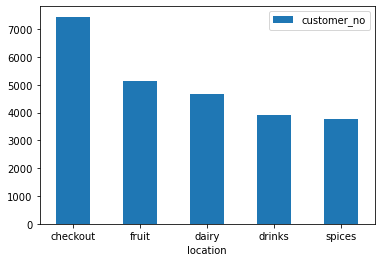

In [1060]:
df.groupby('location')['customer_no'].count().sort_values(ascending=False).plot.bar(rot=0,legend=True);

### Calculate the total number of customers in each section over time

In [942]:
df.groupby(['location','hour'])['customer_no'].count()

location  hour
checkout  7       454
          8       677
          9       455
          10      427
          11      342
                 ... 
spices    17      269
          18      346
          19      389
          20      246
          21      122
Name: customer_no, Length: 76, dtype: int64

In [1061]:
loc_hour=df.groupby(['location','hour'])['customer_no'].count().to_frame().reset_index()

In [1062]:
loc_hour.head()

,location,hour,customer_no
0,checkout,7,454
1,checkout,8,677
2,checkout,9,455
3,checkout,10,427
4,checkout,11,342


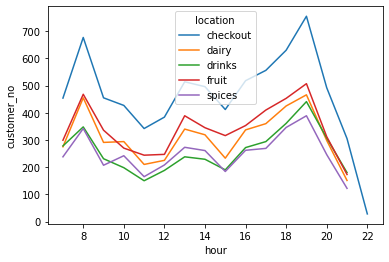

In [1063]:
sns.lineplot('hour','customer_no', hue='location',data=loc_hour);

<AxesSubplot:xlabel='hour'>

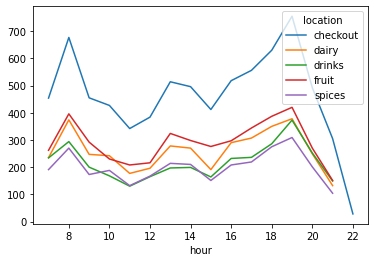

In [838]:
#alternative way
df.groupby(['hour','location'])['customer_no'].nunique().unstack().plot()

### Display the number of customers at checkout over time

In [1064]:
loc_hour[loc_hour['location']=='checkout']

,location,hour,customer_no
0,checkout,7,454
1,checkout,8,677
2,checkout,9,455
3,checkout,10,427
4,checkout,11,342
5,checkout,12,384
6,checkout,13,514
7,checkout,14,496
8,checkout,15,412
9,checkout,16,518


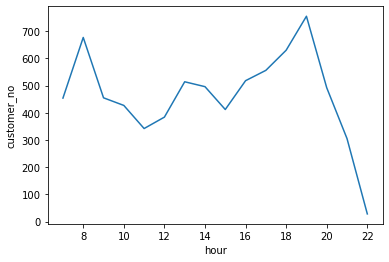

In [1065]:
check_hour=loc_hour[loc_hour['location']=='checkout']
sns.lineplot('hour', 'customer_no', data=check_hour);

### Calculate the time each customer spent in the market

In [1066]:
df=df.reset_index()

In [1067]:
time_spent=df.groupby('customer_no')['timestamp'].max().to_frame()-df.groupby('customer_no')['timestamp'].min().to_frame()

In [1068]:
time_spent=time_spent.reset_index()
time_spent.head()

,customer_no,timestamp
0,1000_fri,0 days 00:01:00
1,1000_mon,0 days 00:07:00
2,1000_thurs,0 days 00:10:00
3,1000_tue,0 days 00:04:00
4,1000_wed,0 days 00:13:00


In [1069]:
time_spent['timestamp']=time_spent['timestamp'] / np.timedelta64(1, 'm')

In [1070]:
time_spent=time_spent.rename(columns={'timestamp':'minutes_spent'})

In [1071]:
time_spent.sort_values(by='minutes_spent', ascending=False)

,customer_no,minutes_spent
160,102_fri,52.0
257,1047_thurs,52.0
5586,666_mon,51.0
5839,710_wed,51.0
1315,1238_fri,49.0
...,...,...
4228,420_tue,1.0
4216,419_mon,1.0
4213,418_tue,1.0
4211,418_mon,1.0


<AxesSubplot:xlabel='minutes_spent', ylabel='Count'>

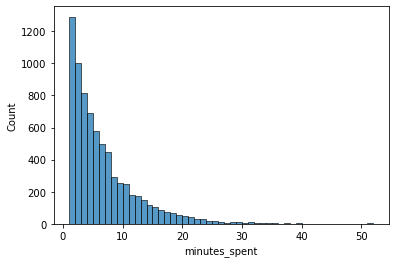

In [1072]:
sns.histplot(time_spent['minutes_spent'], binwidth=1)

### Calculate the total number of customers in the supermarket over time.

In [1073]:
df.groupby(['hour'])['customer_no'].count()

hour
7     1544
8     2290
9     1520
10    1431
11    1111
12    1252
13    1754
14    1650
15    1335
16    1742
17    1889
18    2215
19    2558
20    1655
21     931
22      28
Name: customer_no, dtype: int64

In [1074]:
mon_hour=df.groupby('hour')['customer_no'].count().to_frame().reset_index()

In [1075]:
mon_hour.head()

,hour,customer_no
0,7,1544
1,8,2290
2,9,1520
3,10,1431
4,11,1111


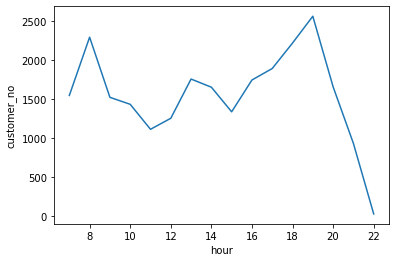

In [1076]:
sns.lineplot('hour','customer_no',data=mon_hour);

### Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

In [1078]:
df.groupby('customer_no')['timestamp','location'].first()

,timestamp,location
customer_no,,
1000_fri,2019-09-06 17:19:00,fruit
1000_mon,2019-09-02 17:44:00,dairy
1000_thurs,2019-09-05 17:23:00,spices
1000_tue,2019-09-03 17:53:00,fruit
1000_wed,2019-09-04 16:53:00,spices
...,...,...
9_fri,2019-09-06 07:06:00,fruit
9_mon,2019-09-02 07:06:00,dairy
9_thurs,2019-09-05 07:07:00,fruit


In [1079]:
first_sec=df.groupby('customer_no')['timestamp','location'].first().reset_index()

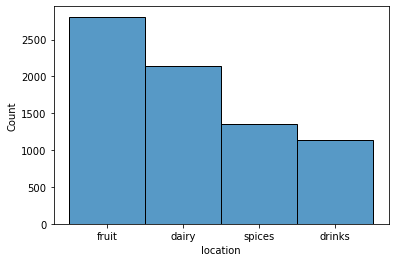

In [1081]:
sns.histplot(first_sec['location']);

In [1082]:
first_sec['first']='first'

In [1083]:
df_test = pd.merge(df, first_sec, how="left", on=["customer_no", "timestamp",'location'])

In [1084]:
df_test['first']=df_test['first'].fillna('follow')

In [1085]:
df_test

,timestamp,customer_no,location,weekday,hour,min,first
0,2019-09-02 07:03:00,1_mon,dairy,monday,7,3,first
1,2019-09-02 07:03:00,2_mon,dairy,monday,7,3,first
2,2019-09-02 07:04:00,3_mon,dairy,monday,7,4,first
3,2019-09-02 07:04:00,4_mon,dairy,monday,7,4,first
4,2019-09-02 07:04:00,5_mon,spices,monday,7,4,first
...,...,...,...,...,...,...,...
24900,2019-09-06 22:00:00,1500_fri,checkout,friday,22,0,follow
24901,2019-09-06 22:00:00,1496_fri,checkout,friday,22,0,follow
24902,2019-09-06 22:00:00,1503_fri,checkout,friday,22,0,follow
24903,2019-09-06 22:00:00,1505_fri,checkout,friday,22,0,follow


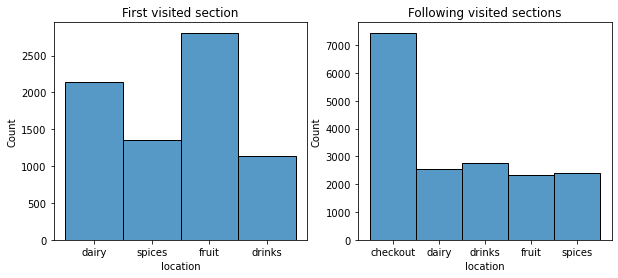

In [1086]:
fig,(ax1,ax2)=plt.subplots(ncols=2)
fig.set_size_inches(10, 4)
sns.histplot(x=df_test[df_test['first']=='first']['location'], data=df_test,ax=ax1).set_title('First visited section')
sns.histplot(x=df_test[df_test['first']=='follow']['location'], data=df_test, ax=ax2).set_title('Following visited sections');

In [832]:
df.groupby(['weekday','location'])['customer_no'].nunique().unstack()

location,checkout,dairy,drinks,fruit,spices
weekday,,,,,
friday,1510,761,688,874,633
monday,1447,720,661,827,584
thursday,1535,782,632,872,613
tuesday,1422,751,581,827,543
wednesday,1531,804,652,884,565


<AxesSubplot:xlabel='weekday'>

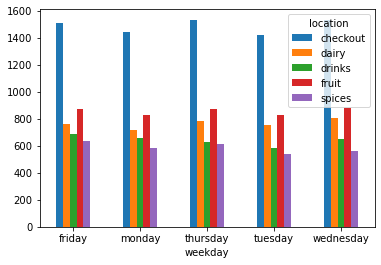

In [818]:
df.groupby(['weekday','location'])['customer_no'].nunique().unstack().plot.bar(rot=0)

### Resampling

In [1089]:
df=df.set_index('timestamp')

In [1090]:
min_data=df.groupby('customer_no').resample('T').ffill()

In [912]:
#data for one customer
min_data[min_data['customer_no']=='1000_mon']

customer_no  location weekday  hour  min
customer_no timestamp                                                   
1000_mon    2019-09-02 17:44:00    1000_mon     dairy  monday    17   44
            2019-09-02 17:45:00    1000_mon     dairy  monday    17   44
            2019-09-02 17:46:00    1000_mon     dairy  monday    17   44
            2019-09-02 17:47:00    1000_mon     dairy  monday    17   44
            2019-09-02 17:48:00    1000_mon     dairy  monday    17   44
            2019-09-02 17:49:00    1000_mon     dairy  monday    17   44
            2019-09-02 17:50:00    1000_mon    drinks  monday    17   50
            2019-09-02 17:51:00    1000_mon  checkout  monday    17   51

In [992]:
min_data

,customer_no,location,weekday,hour,min
timestamp,,,,,
2019-09-06 17:19:00,1000_fri,fruit,friday,17,19
2019-09-06 17:20:00,1000_fri,checkout,friday,17,20
2019-09-02 17:44:00,1000_mon,dairy,monday,17,44
2019-09-02 17:45:00,1000_mon,dairy,monday,17,44
2019-09-02 17:46:00,1000_mon,dairy,monday,17,44
...,...,...,...,...,...
2019-09-03 07:28:00,9_tue,dairy,tuesday,7,23
2019-09-03 07:29:00,9_tue,dairy,tuesday,7,23
2019-09-03 07:30:00,9_tue,checkout,tuesday,7,30


In [1091]:
min_data=min_data.reset_index('timestamp').set_index('timestamp')

In [1146]:
min_data.head(10)

,customer_no,location,weekday,hour,min,before,after
timestamp,,,,,,,
2019-09-06 17:19:00,1000_fri,fruit,friday,17,19,entrance,fruit
2019-09-06 17:20:00,1000_fri,checkout,friday,17,20,fruit,checkout
2019-09-02 17:44:00,1000_mon,dairy,monday,17,44,entrance,dairy
2019-09-02 17:45:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:46:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:47:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:48:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:49:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:50:00,1000_mon,drinks,monday,17,50,dairy,drinks


In [1094]:
min_data['before']=min_data['location'].shift(1)
min_data['after']=min_data['location']
min_data.head(10)

,customer_no,location,weekday,hour,min,before,after
timestamp,,,,,,,
2019-09-06 17:19:00,1000_fri,fruit,friday,17,19,NaN,fruit
2019-09-06 17:20:00,1000_fri,checkout,friday,17,20,fruit,checkout
2019-09-02 17:44:00,1000_mon,dairy,monday,17,44,checkout,dairy
2019-09-02 17:45:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:46:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:47:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:48:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:49:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:50:00,1000_mon,drinks,monday,17,50,dairy,drinks


In [1095]:
min_data['before'].unique()

array([nan, 'fruit', 'checkout', 'dairy', 'drinks', 'spices'],
      dtype=object)

In [1097]:
min_data.loc[min_data['before']=='checkout']

,customer_no,location,weekday,hour,min,before,after
timestamp,,,,,,,
2019-09-02 17:44:00,1000_mon,dairy,monday,17,44,checkout,dairy
2019-09-05 17:23:00,1000_thurs,spices,thursday,17,23,checkout,spices
2019-09-03 17:53:00,1000_tue,fruit,tuesday,17,53,checkout,fruit
2019-09-04 16:53:00,1000_wed,spices,wednesday,16,53,checkout,spices
2019-09-06 17:19:00,1001_fri,fruit,friday,17,19,checkout,fruit
...,...,...,...,...,...,...,...
2019-09-06 07:06:00,9_fri,fruit,friday,7,6,checkout,fruit
2019-09-02 07:06:00,9_mon,dairy,monday,7,6,checkout,dairy
2019-09-05 07:07:00,9_thurs,fruit,thursday,7,7,checkout,fruit


In [1098]:
min_data.loc[min_data['before']=='checkout','before']='entrance'
min_data=min_data.fillna('entrance')

In [1099]:
min_data['before'].unique()

array(['entrance', 'fruit', 'dairy', 'drinks', 'spices'], dtype=object)

In [995]:
min_data.head(10)

,customer_no,location,weekday,hour,min,before,after
timestamp,,,,,,,
2019-09-06 17:19:00,1000_fri,fruit,friday,17,19,entrance,fruit
2019-09-06 17:20:00,1000_fri,checkout,friday,17,20,fruit,checkout
2019-09-02 17:44:00,1000_mon,dairy,monday,17,44,entrance,dairy
2019-09-02 17:45:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:46:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:47:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:48:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:49:00,1000_mon,dairy,monday,17,44,dairy,dairy
2019-09-02 17:50:00,1000_mon,drinks,monday,17,50,dairy,drinks


In [1114]:
mx=pd.crosstab(min_data['before'], min_data['after'],normalize='index')
mx

after,checkout,dairy,drinks,fruit,spices
before,,,,,
dairy,0.102617,0.738910,0.058088,0.049439,0.050946
drinks,0.215290,0.010877,0.599282,0.087737,0.086814
entrance,0.000000,0.287576,0.153526,0.377435,0.181464
fruit,0.200454,0.095376,0.054534,0.599249,0.050387
spices,0.149494,0.191688,0.161820,0.090234,0.406764


In [1137]:
mx['entrance']=[float(i) for i in [0,0,0,0,0]]
mx['exit']=[float(i) for i in [0,0,0,0,0]]

In [1138]:
mx.loc['checkout']=[0,0,0,0,0,0,1]
mx.loc['exit']=[0,0,0,0,0,0,1]

In [1142]:
mx

after,checkout,dairy,drinks,fruit,spices,entrance,exit
before,,,,,,,
dairy,0.102617,0.738910,0.058088,0.049439,0.050946,0.0,0.0
drinks,0.215290,0.010877,0.599282,0.087737,0.086814,0.0,0.0
entrance,0.000000,0.287576,0.153526,0.377435,0.181464,0.0,0.0
fruit,0.200454,0.095376,0.054534,0.599249,0.050387,0.0,0.0
spices,0.149494,0.191688,0.161820,0.090234,0.406764,0.0,0.0
checkout,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
exit,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0


In [1143]:
mx.sum(axis=1)

before
dairy       1.0
drinks      1.0
entrance    1.0
fruit       1.0
spices      1.0
checkout    1.0
exit        1.0
dtype: float64

In [1144]:
mx.to_csv("mx.csv")